# Applied Linear Algebra - Lab 4
Ferdowsi University of Mashhad - Computer Engineering Department

Jan 2024

### Table of Contents
* [PART ONE - Implementing SVD](#part1)
  * [Singular Value Decomposition](#1-svd)
  * [Exercise 1](#1-ex1)

* [PART TWO - Create Word Embeddings](#part2)
  * [Importing Libraries](#import)
  * [Loading The Dataset](#load)
    * [Dataset Information](#dataset_info)
    * [Exercise 1](#ex1)
  * [Preprocessing The Data](#preprocess)
    * [Exercise 2](#ex2)
  * [Creating Vocabulary](#creating_vocab)
  * [Introduction to Natural Language Processing](#intro_nlp)
    * [Word Vectors](#word_vectors)
    * [SVD Based Methods](#SVD_based)
  * [Constructing Co-occurrence Matrix](#constructing)
    * [Exercise 3](#ex3)
    * [Sparse Matrix](#sparse_matrix)
    * [Exercise 4](#ex4)
    * [Exercise 5](#ex5)
  * [Singular Value Decomposition](#2-svd)
    * [Exercise 6](#ex6)
    * [Exercise 7](#ex7)
  * [Cosine Similarity](#cos)
    * [Exercise 8](#ex8)
    * [Exercise 9](#ex9)
    * [Exercise 10](#ex10)
    * [Exercise 11](#ex11)

* [Resources](#resources)


# Part 1- Implementing SVD <a class="anchor" id="part1"></a>

## Singular Value Decomposition <a class="anchor" id="1-svd"></a>

The Singular Value Decomposition (SVD) separates any matrix into simple pieces. it provides a numerically stable matrix decomposition that can be used for
a variety of purposes and is guaranteed to exist.

In many domains, complex systems will generate data that is naturally arranged in
large matrices, or more generally in arrays. For example, a time-series of data from an
experiment or a simulation may be arranged in a matrix with each column containing all of
the measurements at a given time.

The pixel values in a grayscale image may be stored in a matrix,
or these images may be reshaped into large row vectors in a matrix to represent the
frames of a movie. Remarkably, the data generated by these systems are typically low rank,
meaning that there are a few dominant patterns that explain the high-dimensional data. The
SVD is a numerically robust and efficient method of extracting these patterns from data.

Generally, we are interested in analyzing a large data set $X_{n \times d}$:

$$
X = \begin{bmatrix}
\text{---} & x_1 & \text{---} \\
\text{---} & x_2 & \text{---} \\
. & . & . \\
\text{---} & x_n & \text{---} \\
\end{bmatrix}
$$

The rows $x_i \in C_d$ may be measurements from simulations or experiments. For example, columns may represent images that have been reshaped into row vectors with as
many elements as pixels in the image.

The SVD is a unique matrix decomposition that exists for every matrix
 $X_{n \times d}$:

$$
\bf X = \bf U \times \Sigma \times \bf V^\intercal
$$

where $ \bf U_{n \times n}$ is a matrix containing unit eigenvectors of $X X^\intercal$ and $\bf V_{d \times d}$ is containing unit eigenvectors of $X^\intercal X$.

$ \bf \Sigma$ is a diagonal matrix containing square roots of the equal eigenvalues of $ X X^\intercal$ and $X^\intercal X$ (Singular Values $\sigma$.)

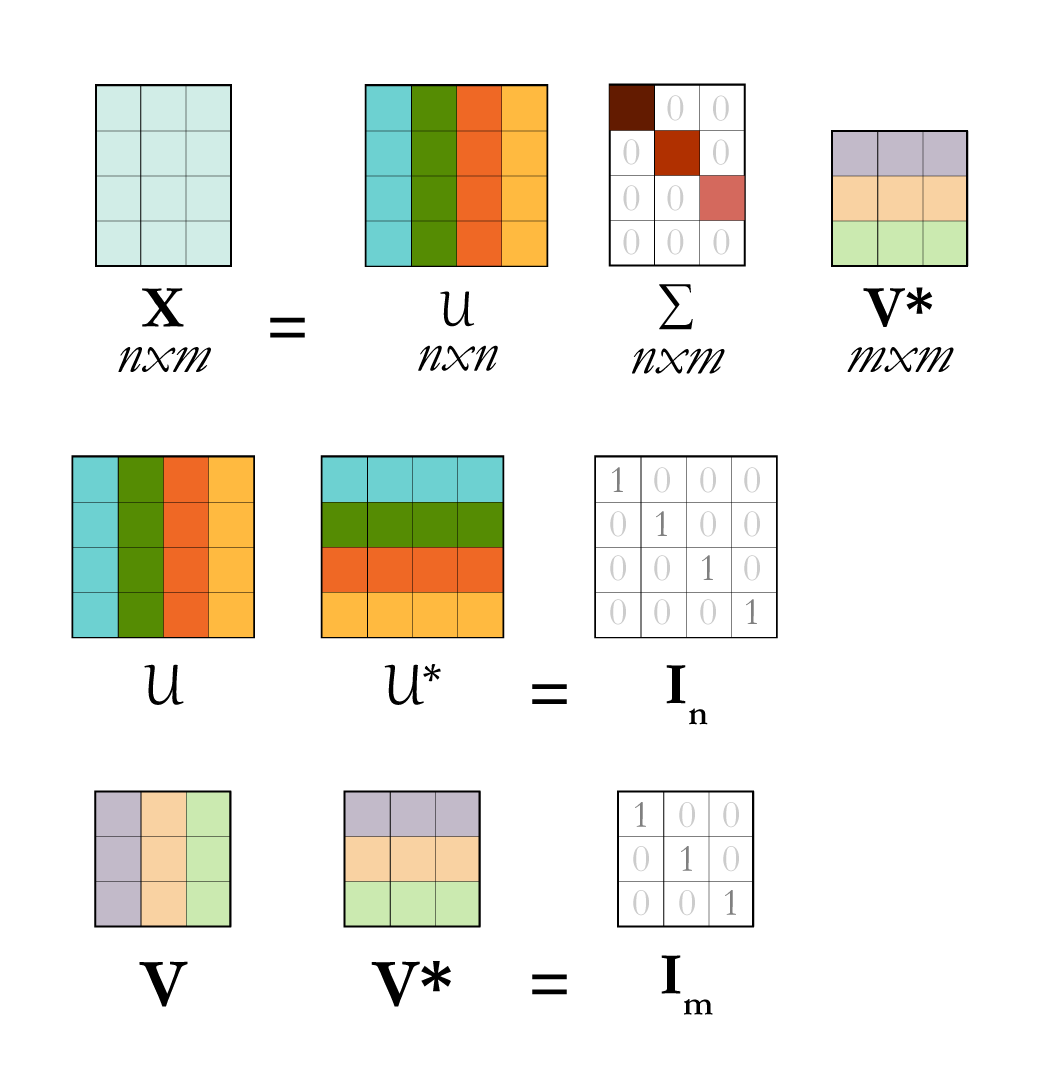

## Exercise 1 <a class="anchor" id="1-ex1"></a>
Define function `svd()` which takes matrix $ \bf X_{n \times d}$ and applies SVD decomposition then returns $ \bf U_{n \times n} , \bf \Sigma_{n \times d},  \bf V^\intercal_{d \times d} $

We've seen steps of SVD decomposition in Chapter 7 of the course.

In [29]:
from numpy.linalg import eig
from numpy import argsort
from numpy import diag

def svd(X):
    # compute X.T * X
    xtx = ...

    # calculate eigenvalues and eigenvectors of XTX
    # use linalg.eig() function, it returns eigenvalues and normalized (unit length) eigenvectors,
    # such that the i-th column
    # is the eigenvector corresponding to the i-th eigenvalue
    eig_vals, V = ...
    # singular values of X are the square root of the non-negative eigenvalues of XtX or XXt
    singular_vals = ...

    # sort both sigular values and matrix V in descending order so that
    # the higher values are placed before the lower ones.
    # use np.argsort(), it returns the indices that would sort an array
    sort_indices = ...
    sort_indices = sort_indices[::-1] #descending
    singular_vals = ...
    V = ...

    # U is matrix of eigenvectors of XXT
    # calculate U using X, V and singular_vals
    U = ...

    # sigma matrix is a diagonal matirx with singular values of X in its diagonal
    # singluar_vals is an array of singular values of X
    sigma = ...

    return U.real, sigma.real, V.T.real

In [2]:
xx = np.random.random((5, 5))
print(xx)
ux, sx, vx = svd(xx)

If your `svd()` implementation is correct, matrix `xx` must be equal to $U \times S \times V$

In [3]:
print('Original matrix: \n', xx)
print('U S V: \n', ux @ sx @ vx)

# Part 2- Create Word Embeddings <a class="anchor" id="part2"></a>

In this part, we are going to create word embeddings using a SVD based method.

First, let's prepare the dataset we are going to work with.

## Importing Libraries <a class="anchor" id="import"></a>

Run the cell below to import all the required libraries.

In [4]:
import gzip
import shutil
from heapq import nlargest

import json, ast, re, os, nltk

nltk.download('punkt')
from operator import itemgetter
import operator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.sparse import dok_matrix
from sklearn.utils.extmath import randomized_svd
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gensim.downloader
import numpy as np
from tqdm import tqdm, trange
from sklearn.decomposition import PCA
from numpy import dot
from numpy.linalg import norm

## Loading The Dataset <a class="anchor" id="load"></a>

First, change directory to the directory you wish to work with.

In [5]:
%cd "/home/..."

In [6]:
BASE_DIR = 'data'
import os
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)

### Dataset Information <a class="anchor" id="dataset_info"></a>

**Web data: Amazon reviews**

This dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review.

Run the cell below to download the dataset.

*You only need to run this cell once.*

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_10.json.gz

You don't have to change the implementation of the following function, but you will use it.

In [5]:
def get_data():
  with gzip.open('reviews_Electronics_10.json.gz', 'rb') as f_in:
    with open('Electronics_10.json', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)
  raw_text=[]
  f = open('Electronics_10.json',)
  for line in f:
    res = ast.literal_eval(line)
    raw_text.append(res["reviewText"].lower())

  f.close()
  return raw_text

### Exercise 1 <a class="anchor" id="ex1"></a>

Using the `get_data()` function, get the raw text data.

For a better understanding of the dataset, print the length of the data and its first entry.

In [6]:
# this may take some time
raw_text = ...
print(...)
print(...)

In [7]:
os.remove("Electronics_10.json")

## Preprocessing The Data <a class="anchor" id="preprocess"></a>

Data preprocessing is the concept of changing the raw data into a clean data set.

You don't have to change the implementation of the following functions, but you will use them.

The `raw_text_to_sentences()` method takes the raw text as input and extracts its sentences into the given file. It returns a dictionary containing each word and its frequency in the dataset, and the total number of words in the dataset.

In [8]:
def raw_text_to_sentences(raw_text, name_to_write: str):
  count_dictionary = {}
  word_count = 1
  f = open(f"{BASE_DIR}/{name_to_write}.txt","x")
  f.close()
  f = open(f"{BASE_DIR}/{name_to_write}.txt","w" )
  for para in raw_text:
    nltk_tokens = nltk.sent_tokenize(para)
    for words in nltk_tokens:
      sent = re.findall("[A-Za-z]+", words)
      line = ""
      for word in sent:
        line = line + ' ' + word.lower()
        word_count += 1
        try:
          count_dictionary[word.lower()] += 1
        except KeyError:
          count_dictionary[word.lower()] = 1
      f.write(line)
      f.write("\n")
  f.close()
  return count_dictionary, word_count

For better results, we can omit the infrequent words. The `remove_infrequent_words()` method removes the words that are repeated less than a specified number from the dataset. This values is passed to the function as "frequency".

In [9]:
def remove_infrequent_words(count_dictionary, frequency, xx, name_to_write: str):
  less_freq_word = 0
  f = open(f"{BASE_DIR}/{name_to_write}.txt", "r")
  lines = f.readlines()
  no_of_lines = len(lines)

  for i in range(no_of_lines):
    x = ""
    words = lines[i].split()
    for word in words:
      try:
        if count_dictionary[word] > frequency and count_dictionary[word] < xx:
          x = x + ' ' + word
        else :
          less_freq_word += 1
      except KeyError:
        pass
    lines[i] = x + "\n"

  f = open(f"{BASE_DIR}/{name_to_write}.txt", "w")
  f.writelines(lines)
  f.close()
  return

### Exercise 2 <a class="anchor" id="ex2"></a>
Use the previous functions to convert the first 1 million enteries of the raw text data to sentences.

Then remove the words whose frequency is less than 5.

In [ ]:
# this may take some time
count_dictionary, word_count = raw_text_to_sentences(..., 'sentences')

d = dict(sorted(count_dictionary.items(), key = itemgetter(1), reverse = True)[:50])
xx = min(d.values())

remove_infrequent_words(count_dictionary, ..., xx, 'sentences')

del raw_text
del d

In [7]:
file = open(f"{BASE_DIR}/sentences.txt","r")
Counter = 0
Content = file.read()
CoList = Content.split("\n")

for i in CoList:
    if i:
        Counter += 1

print("This is the number of lines in the file:")
print(Counter)
file.close()

## Creating Vocabulary <a class="anchor" id="creating_vocab"></a>

You can view the sentences.txt file. It contains 2604766 lines of text.

In this section, we are going to assign each word an index based on its frequency.

In [13]:
f = open(f"{BASE_DIR}/sentences.txt", "r")
lines = f.readlines()
f.close()

The `tf.keras.preprocessing.text.Tokenizer` class allows you to vectorize a text corpus.

The `fit_on_texts()` method updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency.

For example, for the text "*the cat sat on the mat*", it will create a dictionary such as word_index["the"] = 1, word_index["cat"] = 2, ...

It is a word -> index dictionary, so every word gets a unique integer value. Lower integer means more frequent word (often the first few are stop words because they appear a lot).

[further reading](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [14]:
# this may take some time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

# assign indexes to words
word_to_index = tokenizer.word_index
vocab_length = len(word_to_index)

# assign words to indexes
index_to_words = {}
for k,v in word_to_index.items():
    index_to_words[v] = k

In [8]:
index_to_words

You should be able to see that more frequent words such as "had", "there", "these", "do", ... have lower indexes.

We can use the `word_to_index` dictionary to obtain the index of each word, and the `index_to_word` dictionary to do vice versa.

Since the size of the matrices are large, constructing them again can be time consuming. Instead, you can save them and load them later.

Run the cells below to save and load the created vocabulary.

In [16]:
loc = f'{BASE_DIR}/word_to_index.pkl'
with open(loc,'wb') as f:
    pickle.dump(word_to_index, f)

loc = f'{BASE_DIR}/index_to_words.pkl'
with open(loc,'wb') as f:
    pickle.dump(index_to_words, f)

In [18]:
loc = f'{BASE_DIR}/word_to_index.pkl'
infile = open(loc,'rb')
word_to_index = pickle.load(infile)

loc = f'{BASE_DIR}/index_to_words.pkl'
infile = open(loc,'rb')
index_to_words = pickle.load(infile)

vocab_length = len(word_to_index)

## Introduction to Natural Language Processing <a class="anchor" id="intro_nlp"></a>

The goal of NLP is to be able to design algorithms to allow computers to "understand" natural language in order to perform some task.

The first and arguably most important common denominator across all NLP tasks is how we represent words as input to any and all of our models.

To perform well on most NLP tasks we first need to have some notion of similarity and difference between words. With word vectors, we can quite easily encode this ability in the vectors themselves (using distance measures such as
Jaccard, Cosine, Euclidean, etc).


### Word Vectors <a class="anchor" id="word_vectors"></a>

There are an estimated 13 million tokens for the English language, but are they all completely unrelated? Feline to cat, hotel to motel? I think not. Thus, we want to encode word tokens each into some vector that represents a point in some sort of "word" space.

The most intuitive reason for this, is that perhaps there actually exists some N-dimensional space (such that N <= 13 million) that is sufficient to encode all semantics of our language.

Each dimension would encode some meaning that we transfer using speech.

### SVD Based Methods <a class="anchor" id="SVD_based"></a>

For this class of methods to find word embeddings (otherwise known as word
vectors), we first loop over a massive dataset and accumulate word co-occurrence counts in some form of a matrix $X$. We have already prepared the dataset in the previous sections.

This step is done in the next section: [Constructing Co-occurrence Matrix](#constructing)

We then perform Singular Value Decomposition on $X$ to get a $USV^T$ decomposition. We use the rows of U as the word embeddings for all words in our dictionary.

This step is done in the section: [Singular Value Decomposition](#2-svd)

## Constructing Co-occurrence Matrix <a class="anchor" id="constructing"></a>

**Window based Co-occurrence Matrix**

We make the bold conjecture that words that are related will often appear within a small window from one another. For instance, "banks", "bonds", "stocks", "money", etc. are probably likely to appear together. But "banks", "octopus", "banana", and "hockey" would probably not consistently appear together.

We use this fact to build a co-occurrence matrix, $X$, in the following manner:

Loop over the dataset and for each time word $i$ appears in a certain distance (window) from word $j$, we add one to entry $X_{ij}$.

In this method, we count the number of times each word appears inside a
window of a particular size around the word of interest. We calculate
this count for all the words in corpus.


We display an example below.

Let our corpus contain just three sentences and the window size be 1:
1. I enjoy flying.
2. I like NLP.
3. I like deep learning.

The resulting co-occurrence matrix will then be:

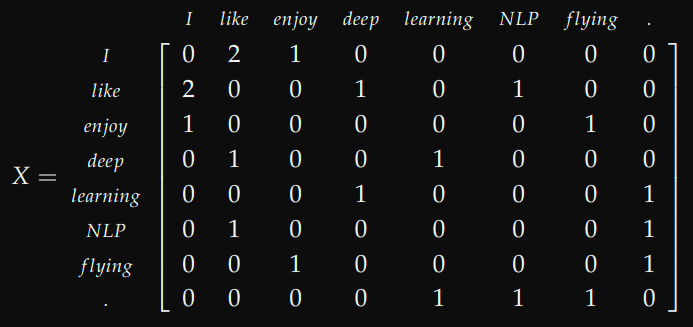

### Exercise 3 <a class="anchor" id="ex3"></a>
As you can see, most of the elements of the resulting co-occurence matrix, $X$, have 0 value. Why is this true? Would the same thing happen for another corpus?

In [ ]:
# write your answer in this cell

### Sparse Matrix <a class="anchor" id="sparse_matrix"></a>

If most of the elements of a matrix have 0 value, then it is called **a sparse matrix**.
For example:

$$
X =
\begin{pmatrix}
0 & 0 & 3 & 0 & 4 \\
0 & 0 & 5 & 7 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 2 & 6 & 0 & 0 \\
\end{pmatrix}
$$

Representing a sparse matrix by a 2D array leads to wastage of lots of memory as zeroes in the matrix are of no use in most of the cases. So, instead of storing zeroes with non-zero elements, we only store non-zero elements. This means storing non-zero elemenarray leads to wastage of lots of memoryts with triples (Row, Column, value).

The two major benefits of using sparse matrix instead of a simple matrix are:

**Storage:** There are lesser non-zero elements than zeros and thus lesser memory can be used to store only those elements.

**Computing time:** Computing time can be saved by logically designing a data structure traversing only non-zero elements.

Sparse matrices are generally utilized in applied machine learning such as in data containing data-encodings that map categories to count and also in entire subfields of machine learning such as natural language processing (NLP).

Since most of the elements of the mentioned co-occurence matrix, $X$, have 0 value, we are going ot use a sparse matrix.

### Exercise 4 <a class="anchor" id="ex4"></a>
Complete the `create_co_oc_matrix()` method. In this method, we count the number of times each word appears inside a window of a particular size around the word of interest. We calculate this count for all the words in corpus.

Set the window size to 2; meaning that only the 2 words after and the 2 words before any given word should be considered.

In [27]:
def create_co_oc_matrix(data):
  d = {}
  for line in data:
    line = line[:-1]
    words = line.split()
    no_of_words = len(words)
    index = 0
    for word in words:
      k = word_to_index[word]
      start = ...
      end = ...
      for i in range(start, end + 1):
        if 0 <= i < index or index < i < no_of_words:
          try:
            d[k, word_to_index[words[i]]] += 1
          except KeyError:
            d[k, word_to_index[words[i]]] = 1
      index += 1
  return d

### Exercise 5 <a class="anchor" id="ex5"></a>
Using the `create_co_oc_matrix()` method, construct the co-occurence matrix for our dataset.

In [19]:
# this may take some time
cooccurence_matrix = ...

In [9]:
cooccurence_matrix

The constructed co-occurence matrix is a dictionary. We can use it to build a sparse matrix.

The `scipy.sparse.dok_matrix` class is an efficient structure for constructing sparse matrices incrementally. This can be instantiated in several ways, such as with the matrix we constructed (`cooccurence_matrix`).

[further reading](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html)

In [22]:
X = dok_matrix((vocab_length + 1, vocab_length + 1))
for k, v in cooccurence_matrix.keys():
    X[k, v] = cooccurence_matrix[k, v]

del lines
del cooccurence_matrix

In [10]:
X.shape

$X$ is the co-occurence matrix for our dataset, and it is a sparse matrix.

Run the cells below to save and load the co-occurence matrix $X$.

In [ ]:
loc = f'{BASE_DIR}/co_occure_mat.pkl'
with open(loc,'wb') as f:
    pickle.dump(X, f)

In [ ]:
loc = f'{BASE_DIR}/co_occure_mat.pkl'
infile = open(loc,'rb')
X = pickle.load(infile)

## Singular Value Decomposition <a class="anchor" id="2-svd"></a>

In this section, we perform Singular Value Decomposition on the co-occurence matrix $X$, to get a $USV^T$ decomposition.

### Exercise 6 <a class="anchor" id="ex6"></a>
Using the `svd()` method you implemented in [part one](#part1), apply SVD on $X$.

In [ ]:
ux, sx, vx = ...

As you can see, using your simple implementation of SVD takes a long time to compute resutls. Therefore, it is not efficient for large matrices.

The `sklearn.utils.extmath.randomized_svd()` method compute a truncated randomized SVD. This algorithm finds a (usually very good) approximate truncated singular value decomposition using randomization to speed up the computations. It is particularly fast on large matrices on which you wish to extract only a small number of components.

`n_components` is the number of singular values and vectors to extract, which is passed to the method.

[further reading](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html)

### Exercise 7 <a class="anchor" id="ex7"></a>
Use the `randomized_svd()` method to apply SVD on $X$. Set `n_components` to 100.

Remember we are using 1 million entries from the dataset. If the computation takes long, you can use a smaller portion. However, if the dataset becomes too small, the word embeddings would be meaningless.

In [10]:
u, s_matrix, vt_matrix = ...

Run the cells below to save and load the results.

In [ ]:
loc = f'{BASE_DIR}/u.pkl'
with open(loc,'wb') as f:
    pickle.dump(u, f)

loc = f'{BASE_DIR}/s.pkl'
with open(loc,'wb') as f:
    pickle.dump(s_matrix, f)

loc = f'{BASE_DIR}/v.pkl'
with open(loc,'wb') as f:
    pickle.dump(vt_matrix, f)

In [9]:
loc = f'{BASE_DIR}/u.pkl'
infile = open(loc,'rb')
u = pickle.load(infile)

loc = f'{BASE_DIR}/s.pkl'
infile = open(loc,'rb')
s_matrix = pickle.load(infile)

loc = f'{BASE_DIR}/v.pkl'
infile = open(loc,'rb')
v_matirx = pickle.load(infile)

## Cosine Similarity <a class="anchor" id="cos"></a>

In the previous section, we performed Singular Value Decomposition on $X$ to get a $USV^T$ decomposition.

To create the word embeddings for all words in our dictionary, we can eaither:

1. Use the rows of $U$ or
2. Use the rows of $US$

### Exercise 8 <a class="anchor" id="ex8"></a>
Explain the difference between using $U$ and using $US$ to create the word embeddings.

In [ ]:
# write your answer in this cell

To perform well on most NLP tasks we first need to have some notion of similarity and difference between words.

With word embeddings, we can quite easily encode this ability in the vectors themselves (using distance measures such as
Jaccard, Cosine, Euclidean, etc).

We use the rows of $U$ as the word embeddings, and cosine similarity to measure the distance between the words.

**Cosine similarity**

It measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.

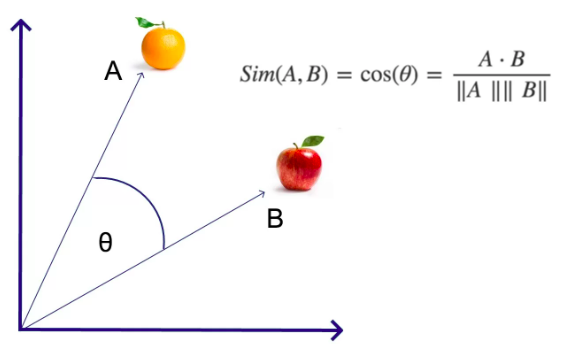

### Exercise 9 <a class="anchor" id="ex9"></a>
Define the word representation matrix (word embeddings) and print its shape.

Why is this the shape of the matrix?

In [11]:
word_rep_mat = ...
print(...)

# write your answer below
# 

### Exercise 10 <a class="anchor" id="ex10"></a>
Implement the `cosine_similarity()` method.

In [29]:
def cosine_similarity(v1,v2):
  result = ...
  return result

### Exercise 11 <a class="anchor" id="ex11"></a>
Complete the cell below to find the top 20 closest words to each word in the `words` array.

The inner for loop finds the distance between the given word with every other word in the dataset. This distance is measured with cosine similarity using the `cosine_similarity()` method defined above.

Then, the top 20 words with the minimum distance are chosen as the most similar.

In [13]:
words = ["husband","shipping","truck","road","beautiful"]

In [12]:
for word in words:
  dist_matrix = {}
  x = word_to_index[word]
  dist_matrix[x] = 0

  embedings = []
  top_words = []
  for i in range(1, vocab_length):
    if i != x:
      dist_matrix[i] = ...

  Highest = nlargest(20, dist_matrix, key = dist_matrix.get)
  print("Top 20 closest words for: ", end = word)
  print()
  for val in Highest:
    print(index_to_words[val])
    embedings.append(u[val])
    top_words.append(index_to_words[val])
  print("---------------------------------------")

### Exercise 12 <a class="anchor" id="ex12"></a>

Remember we removed the words with a frequency less that 5 with the `remove_infrequent_words()` method. Hows the result different if we use frequency = 0, 1, 2, 10? why?

In [ ]:
# write your answer in this cell

## Resources <a class="anchor" id="resources"></a>

- https://cs224d.stanford.edu/lecture_notes/notes1.pdf
- https://towardsdatascience.com/art-of-vector-representation-of-words-5e85c59fee5
- Dataset: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/
- https://github.com/somyalalwani/Word-Embedding-using-SVD/blob/main/2020201092_NLP_Q1.ipynb
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html
- https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html